## __Plato Notebook 5a: Effects of sediment subduction on global plate motion__

Thomas Schouten, Whitney Behr, Edward Clennett and Thorsten Becker

This jupyter notebook provides a walkthrough of the Plato algorithm applied to calculate theoretical velocity increases resulting from sediment lubrication.

#### __0. Prepare Python__

First, we load the required packages and set the plotting parameters.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

In [2]:
# Load excel file with settings
settings_file = os.path.join(os.getcwd(), "settings.xlsx")

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "05a-Effects_of_sediment_subduction"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "05a-Effects_of_sediment_subduction"))

# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 20
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

#### __1.1 Slab pull calculation__

In the Plato algorithm the effect of sediment subduction on the slab pull torque is implemented as an interface term that scales logarithmically with the fraction of the interface that is occupied by sediments, whereby the sediment fraction is calculated by dividing the sediment thickness by the shear zone width and assuming the rest is filled with basalt (i.e. for a shear zone width of 2 km, a slab with a 600 m thick sediment cover will be result in an interface that is filled with 30% sediment and 70% basalt).

The below cell contains the function to calculate slab pull torque:

In [3]:
def compute_interface_term(sediment_fraction, C=0.0321):
    """
    Function to calculate the interface term that accounts for resisting forces at the subduction interface.
    These forces are i) shearing along the plate interface, ii) bending of the slab, and iii) vertical resistance to slab sinking.
    The value of C0 is obtained from the optimisation of the slab pull force (see below).

    :param sediment_fraction:   fraction of the subduction interface occupied by sediments
    :type sediment_fraction:    float, array
    :param C0:                  constant that scales the interface term
    :type C0:                   float

    :return:                    interface term for the slab pull force
    :rtype:                     float, array
    """
    # Calculate interface term for all components of the slab pull force
    interface_term = C * (11 - 10**(1-sediment_fraction))
    
    return interface_term

def calculate_slab_thickness(ages):
    """
    Function to calculate thickness of slab as a function of oceanic age
    """
    # Constants
    kappa = 1e-6                            # thermal diffusivity [m2/s]
    ma2s = 1e6 * 365.25 * 24 * 60 * 60      # Ma to s

    return 2.32 * np.sqrt(kappa * ages * ma2s)

def calculate_slab_pull_force(slab_thickness):
    """
    Function to calculate the slab pull force.

    :param slab_thickness:      thickness of the slab [m]
    :type slab_thickness:       float, array

    :return:                    slab pull force [N]
    :rtype:                     float, array
    """
    # Set mechanical properties
    g = 9.81                        # acceleration due to gravity [m/s2]
    dT = 1200                       # mantle-surface T contrast [K]
    alpha = 3e-5                    # thermal expansivity [K-1]
    rho0 = 3300                     # reference mantle density  [kg/m3]
    depth = 700e3                   # depth of slab [m]
    drho_slab = rho0 * alpha * dT   # slab density contrast [kg/m3]

    # Calculate slab pull force
    return slab_thickness * depth * drho_slab * g


The below cells calculate the slab pull force for a range of plausible plate ages and sediment fractions in the interface.

In [4]:
# Set ranges for age and sediment fraction
age_range = np.linspace(0, 250., 1001)
sediment_fraction_range = np.linspace(0, 1, 1001)

# Create meshgrid
ages, sediment_fractions = np.meshgrid(age_range, sediment_fraction_range)

In [5]:
# Calculate slab thickness and slab pull force
slab_thickness = calculate_slab_thickness(ages)

# Calculate slab pull force
slab_pull_force = calculate_slab_pull_force(slab_thickness)

# Calculate interface term
interface_term = compute_interface_term(sediment_fractions)

# Calculate effective slab pull force
slab_pull_force_eff = slab_pull_force * interface_term

The below cell visualises the value of the interface term as a function of sediment thickness and slab age, like figure S1.

In [8]:
print(os.path.join(figs_dir, "Sediment_thickness_vs_Interface_term.png"))

import os

if not os.path.exists(figs_dir):
    print(f"Directory doesn't exist: {figs_dir}")
else:
    print(f"Directory exists: {figs_dir}")

/Users/thomas/Documents/figures_notebooks/05a-Effects_of_sediment_subduction/Sediment_thickness_vs_Interface_term.png
Directory doesn't exist: /Users/thomas/Documents/figures_notebooks/05a-Effects_of_sediment_subduction


FileNotFoundError: [Errno 2] No such file or directory: '/Users/thomas/Documents/figures_notebooks/05a-Effects_of_sediment_subduction/Sediment_thickness_vs_Interface_term.png'

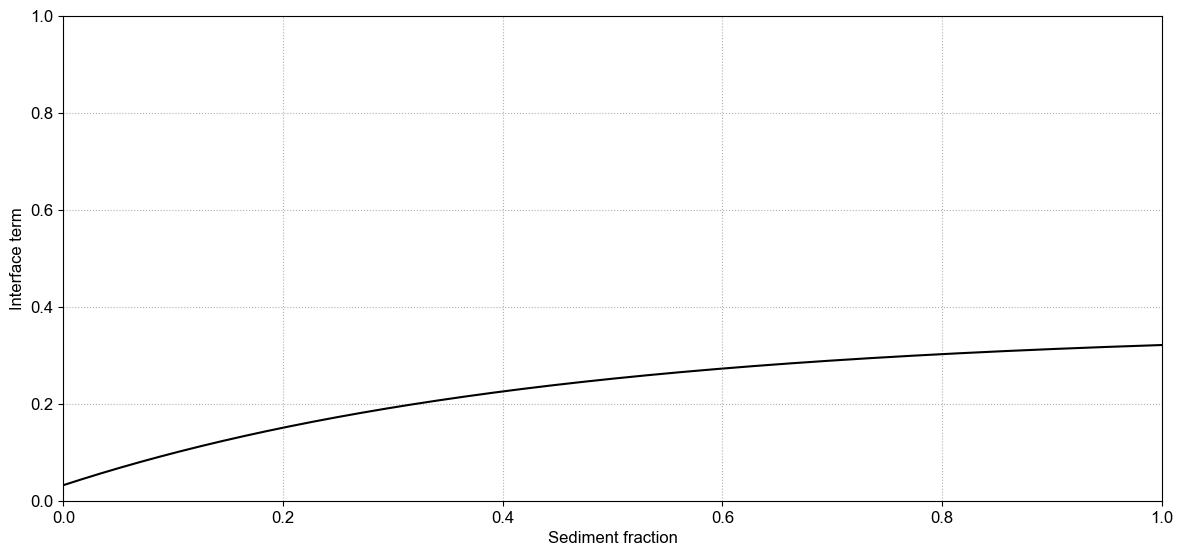

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height_graphs))
ax.plot(sediment_fraction_range, interface_term[:, 0], color="black")
ax.set_xlabel("Sediment fraction")
ax.set_ylabel("Interface term")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(ls=":")
# ax.set_yscale("log")
fig.savefig(os.path.join(figs_dir, "Sediment_thickness_vs_Interface_term.png"), bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
c = ax.imshow(
    slab_pull_force_eff,
    cmap="cmc.batlow",
    extent=[0,250,1,0],
    )
ax.set_aspect(2.5e2)
ax.set_xlabel("Plate age [Ma]")
ax.set_ylabel("Sediment fraction")
ax.invert_yaxis()
fig.colorbar(c, label="Slab pull force [N]", aspect=20)

fig.savefig("Figures/Slab_pull_force.png", bbox_inches="tight", dpi=300)
plt.show()

NameError: name 'fig_height' is not defined